# Blank Factory

## Subroutines

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cmath import pi,acos,exp,sqrt
def plotArc(ax,P0,n0,l,da,tol=0.001,c=None):
  if l==0:
    return
  x=np.linspace(0,l,max(2,int(abs(6*(da/(2*pi)))),int(l//(2*abs(2*l/da*tol)**0.5)+1))if (da!=0) and (l!=0) else 2)
  phi2=x/l*da/2
  p=P0+x*np.sinc(phi2/pi)*n0*np.exp(1j*phi2)
  if c==None:
    ax.plot(p.real,p.imag)
  else:
    ax.plot(p.real,p.imag,c)
    
def plotArcchain(ax,P0,n0,arcs,c=None):
    p=P0
    n=n0
    for l,da in arcs:
        plotArc(ax,p,n,l,da,c=c)
        p+=l*np.sinc(da/(2*pi))*n*exp(1j*da/2)
        n*=exp(1j*da)
        
def calcTangent(c1,r1,c2,r2):
    c2_c1=(c2-c1)
    lcc=abs(c2_c1) 
    ec2_c1=c2_c1/lcc
    cosphi=((r1+r2)/lcc)
    sinphi=sqrt(1-cosphi**2)
    phi=-cosphi+1j*sinphi
    t1=c1-r1*ec2_c1*phi
    t2=c2+r2*ec2_c1*phi
    return [t1,t2]

### linear mesh

In [2]:
import matplotlib.pyplot as plt
import numpy
import cmath  
    
%matplotlib notebook

Data=dict(l1=0.15, r1=0.1, l2=0.15, r2=0.1,strands=5,phi_rim=0.2)
def update_plot():
  l1,r1,l2,r2,strands= [Data[key] for key in ('l1','r1','l2','r2','strands')]
  output1.clear_output(wait=True)
  with output1:
    %matplotlib inline
    fig=plt.figure(figsize=(3,3)) 
    ax=fig.add_subplot(1,1,1)  
    plotArcchain(ax,0+0j,1+0j,((l1,0),(r1*2*pi,2*pi)))
    c1=l1+1j*r1
    ax.plot(c1.real,c1.imag,('k+'))
    plotArcchain(ax,1+1j,-1+0j,((l2,0),(r2*2*pi,2*pi)))
    c2=(1-l2)+1j*(1-r2)
    ax.plot(c2.real,c2.imag,'k+') 
    t1,t2=calcTangent(c1,r1,c2,r2)
    ax.plot([t1.real,t2.real],[t1.imag,t2.imag])  
    ax.set_aspect('equal')
    ax.set_aspect(1.0)
    display(fig)
    plt.close()
  output2.clear_output(wait=True)
  with output2:
    fig=plt.figure(figsize=(12,3 )) 
    ax=fig.add_subplot(1,1,1)  
    ltan,phitan=cmath.polar(t2-t1)
    phitan%=2*pi
    arcs=[(l1,0),(r1*phitan,phitan),(ltan,0),(r2*phitan,-phitan),(l2,0)]
    arcs=(arcs+arcs[-1::-1])*2
    for i in range(strands):
      p0=2*i/strands+0j
      n0=1+0j
      plotArcchain(ax,p0,n0,arcs,c=['r','g','b','y','k'][i])
    ax.set_xlim(0,4)
    ax.set_aspect('equal')
    display(fig)
    plt.close()
  output3.clear_output(wait=True)
  with output3:
    print(f'{l1=:0.3f}, {r1=:0.3f}, {l2=:0.3f}, {r2=:0.3f}, {strands=:d}')
  plt.close()

from ipywidgets import widgets,HBox,VBox
output1=widgets.Output() 
output2=widgets.Output()
output3=widgets.Output()
def handle_change(msg):
  Data[msg['owner'].description] = msg['new']
  update_plot()

widgetList1=dict()

key='l1'
widgetList1[key]=widgets.FloatSlider(description=key,
            min=0.0,max=1.0,value=Data[key],step=0.01,continuous_update=False, orientation='horizontal',
            readout_format='0.3f')
key='r1'
widgetList1[key]=widgets.FloatSlider(description=key,
            min=0.0,max=1.0,value=Data[key],step=0.01,continuous_update=False, orientation='horizontal',
            readout_format='0.3f')
key='l2'
widgetList1[key]=widgets.FloatSlider(description=key,
            min=0.0,max=1.0,value=Data[key],step=0.01,continuous_update=False, orientation='horizontal',   
           readout_format='0.3f')
key='r2'
widgetList1[key]=widgets.FloatSlider(description=key,
            min=0.0,max=1.0,value=Data[key],step=0.01,continuous_update=False, orientation='horizontal',
            readout_format='0.3f')
key='strands'
widgetList1[key]=widgets.BoundedIntText(description=key,
            min=1,max=5,value=Data[key],step=1,continuous_update=False,layout={'widtht':'1in'},
            readout_format='d')
widgetList1['strands'].layout.width='1.5in'

for  w in widgetList1.values():
    w.observe(handle_change,'value')
    if hasattr(w,'orientation'):
        if w.orientation=='horizontal':
          w.layout.width='5in'
        else:
          w.layout.height='4in'

Layout1=VBox(
        [
        HBox([VBox([widgets.HTML(value="<h2>Parameters</h2>"),widgetList1['l1'], widgetList1['r1'],widgetList1['l2'],widgetList1['r2'],widgetList1['strands']],), output1,],),
        output2,
        output3
        ])
update_plot();

### circular mesh

In [3]:
from cmath import pi
circularData=dict(r_rim= 10.000, r_hub=3.000, n_spokes=13, n_strands=5,
                  phi_rim=0.160, r_fillet_rim=0.060, phi_hub=0.050, r_fillet_hub=0.200,)
                    

def update_circular_plot():
  keys=['r_rim','r_hub','n_spokes','phi_rim', 'r_fillet_rim', 'phi_hub', 'r_fillet_hub','n_strands']
  r_rim,r_hub,n_spokes,phi_rim, r_fillet_rim, phi_hub, r_fillet_hub,n_strands= [circularData[key] for key in  keys]
  output4.clear_output(wait=True)
  phi_tot=2*pi*n_strands
  phi_spoke2=phi_tot/(2*n_spokes)
  l1,r1,l2,r2=phi_rim*phi_spoke2*r_rim,r_fillet_rim*phi_spoke2*r_rim,phi_hub*phi_spoke2*r_hub,r_fillet_hub*phi_spoke2*r_hub
  with output4:
    %matplotlib inline
    fig=plt.figure(figsize=(4,4)) 
    ax=fig.add_subplot(1,1,1)  
    ax.plot(0,0,'+')
    ax.plot((0,0),(0,-r_rim),'k-.')
    p=-1j*r_rim*exp(1j*phi_spoke2)
    ax.plot((0,p.real),(0,p.imag),'k-.')
    plotArcchain(ax,0-1j*r_rim,1+0j,((l1,phi_rim*phi_spoke2),(r1*2*pi,2*pi)))
    c1=(0-1j*(r_rim-r1))*exp(1j*phi_rim*phi_spoke2)
    ax.plot(c1.real,c1.imag,('k+'))
    plotArcchain(ax,(0-1j*r_hub)*exp(1j*phi_spoke2),(-1+0j)*exp(1j*phi_spoke2),((l2,-phi_hub*phi_spoke2),(r2*2*pi,2*pi)))
    c2=(0-1j*(r_hub+r2))*exp(1j*((1-phi_hub)*phi_spoke2))
    ax.plot(c2.real,c2.imag,'k+') 
    t1,t2=calcTangent(c1,r1,c2,r2)
    ax.plot([t1.real,t2.real],[t1.imag,t2.imag])  
    ax.set_aspect('equal')
    ax.set_aspect(1.0)
    display(fig)
    plt.close()
  output5.clear_output(wait=True)
  with output5:
    fig=plt.figure(figsize=(6,6)) 
    ax=fig.add_subplot(1,1,1)  
    ltan,phitan=cmath.polar(t2-t1)
    phitan%=2*pi
    arcs=[(l1,phi_rim*phi_spoke2),(r1*(phitan-phi_rim*phi_spoke2),phitan-phi_rim*phi_spoke2),(ltan,0),(r2*(phitan-((1-phi_hub)*phi_spoke2)),-phitan+((1-phi_hub)*phi_spoke2)),(l2,phi_hub*phi_spoke2)]
    arcs=(arcs+arcs[-1::-1])*n_spokes
    p0=0-1j*r_rim
    n0=1+0j
    plotArcchain(ax,p0,n0,arcs,c='b')
    ax.set_aspect('equal')
    display(fig)
    plt.close()
  output6.clear_output(wait=True)
  with output6:
    print(f'{r_rim=: 0.3f}, {r_hub=:0.3f}, {n_spokes=:d}, {n_strands=:d},')
    print(f'{phi_rim=:0.3f}, {r_fillet_rim=:0.3f}, {phi_hub=:0.3f}, {r_fillet_hub=:0.3f},')
    print()
    print(f'mesh={arcs[:5]}')
    
  plt.close()

from ipywidgets import widgets,HBox,VBox
output4=widgets.Output() 
output5=widgets.Output()
output6=widgets.Output()

def handle_change_circular(msg):
  circularData[msg['owner'].description] = msg['new']
  update_circular_plot()
widgetList2={}
key='r_rim'
widgetList2[key]=widgets.FloatText(description=key,
            value=circularData[key],continuous_update=False,layout={'width':'1.5in'},
            readout_format='0.3f')
key='r_hub'
widgetList2[key]=widgets.FloatText(description=key,
            value=circularData[key],continuous_update=False,layout={'width':'1.5in'},
            readout_format='0.3f')
key='n_spokes'
widgetList2[key]=widgets.IntText(description=key,
            value=circularData[key],step=1,continuous_update=False,layout={'width':'1.5in'},
            readout_format='d')
key='n_strands'
widgetList2[key]=widgets.BoundedIntText(description=key,
            min=1,max=5,value=circularData[key],step=1,continuous_update=False,layout={'width':'1.5in'},
            readout_format='d')

key='phi_rim'
widgetList2[key]=widgets.FloatText(description=key,
            value=circularData[key],step=0.01,continuous_update=False, layout={'width':'1.5in'},
            readout_format='0.3f')
key='r_fillet_rim'
widgetList2[key]=widgets.FloatText(description=key,
            value=circularData[key],step=0.01,continuous_update=False, layout={'width':'1.5in'},
            readout_format='0.3f')
key='phi_hub'
widgetList2[key]=widgets.FloatText(description=key,
            value=circularData[key],step=0.01,continuous_update=False, layout={'width':'1.5in'},
           readout_format='0.3f')
key='r_fillet_hub'
widgetList2[key]=widgets.FloatText(description=key,
            value=circularData[key],step=0.01,continuous_update=False, layout={'width':'1.5in'},
            readout_format='0.3f')

for  w in widgetList2.values():
    w.observe(handle_change_circular,'value')
    if hasattr(w,'orientation'):
        if w.orientation=='horizontal':
          w.layout.width='5in'
        else:
          w.layout.height='4in'

Layout2=VBox(
        [HBox([
        VBox([HBox([VBox([widgetList2['r_rim'],widgetList2['r_hub'],widgetList2['n_spokes'],widgetList2['n_strands']],),VBox([widgetList2['phi_rim'], widgetList2['r_fillet_rim'],widgetList2['phi_hub'],widgetList2['r_fillet_hub'],]),],),
             output4]),
        output5,]),
        output6
        ])
update_circular_plot();
plt.close()

In [4]:
Layout=widgets.Tab([Layout1,Layout2],titles=['Linear','Circular'],selected_index=1)

## Interactive Section

In [5]:
display(Layout);

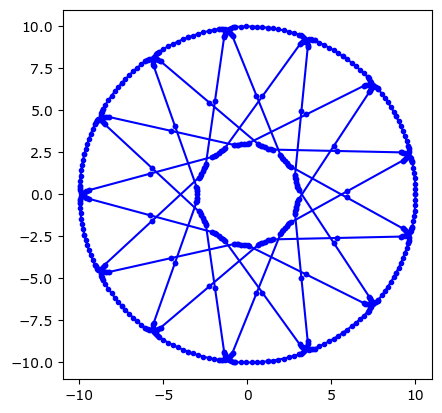

In [6]:
mesh=[(1.9332877868244882, 0.19332877868244883), (0.9828934574183111, 1.3557470531003324), (7.606729771262475/2, 0),(7.606729771262475/2, 0), (0.2908531488212172, -0.40118620835574137), (0.18124573001479577, 0.060415243338265257)]
plotArcchain(plt.gca(),10,1j,(mesh+mesh[-1::-1])*13,c='b.-')
plt.gca().set_aspect('equal') 